In [1]:
import numpy as np
import matplotlib.pyplot as plt
from typing import *

In [2]:
%load_ext autoreload
%autoreload 2


In [3]:
%matplotlib inline

In [4]:
plt.rcParams["figure.figsize"] = 40,10
plt.rcParams["font.size"] = 15

In [5]:
from one.utils import *
from one.data.ucrdata import UcrDataReader

In [6]:
ROOT_DIR = "./data/ucr/"
files = get_files_from_path("./data/ucr")

In [7]:
d = UcrDataReader()
file = d(ROOT_DIR+files[143])

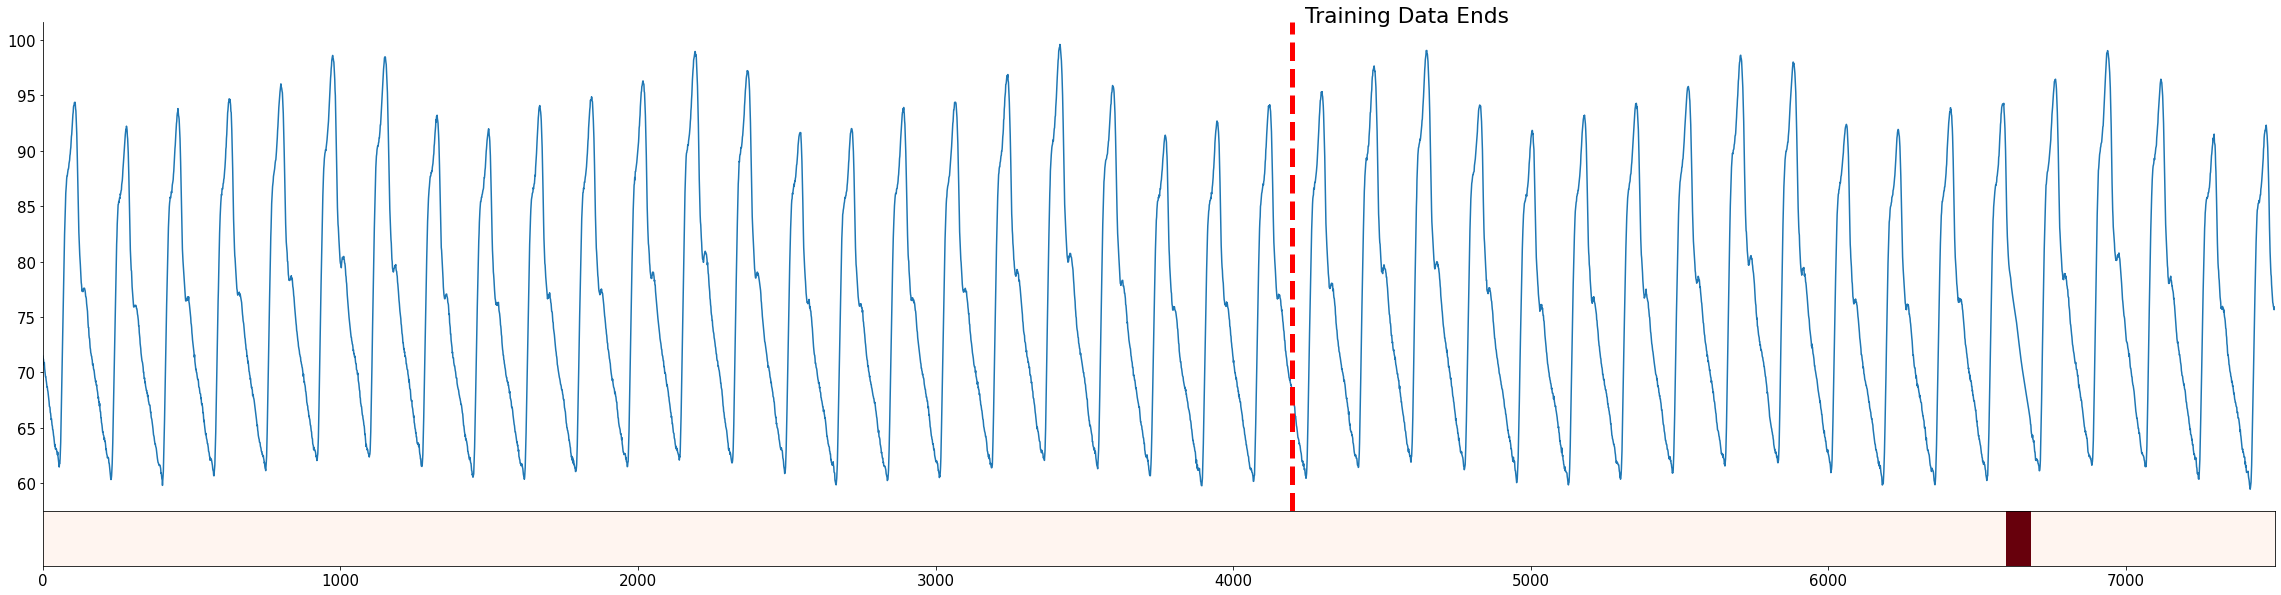

In [8]:
p = graph_data(file.series, file.labels, file.train_len)

# Experiment

In [ ]:
import os 

from one.utils import *
from one.models import *
from one.data.ucrdata import UcrDataReader

In [ ]:
ROOT_DIR = "./data/ucr/"
SAVE_DIR = "./results/"

SIMPLE_MODELS = [LightGBMModel, RandomForestModel, RegressionModel]
DL_MODELS = [NBEATSModel, NHiTSModel, TCNModel, TFTModel, TransformerModel]
RNN_MODELS = ["RNN", "LSTM", "GRU"]

files = get_files_from_path(ROOT_DIR)

In [ ]:
def run_model(m, data, fdir):
        os.makedirs(fdir, exist_ok=True)
        
        train_data, train_label = data.train
        test_data, test_label = data.test
        
        m.hyperopt_ws(train_data, test_data, 30)

        model_test_data, model_test_label = data.get_test_with_window(m.window)
        
        m.hyperopt_model(train_data, model_test_data, 50)
        m.fit(train_data)

        score, _, preds = m.get_scores(model_test_data)

        save_model_output(score, m, f"{fdir}{m.model_name}_scores.txt")
        save_model_output(preds, m, f"{fdir}{m.model_name}_preds.txt")

In [ ]:
reader = UcrDataReader()

for file in files:
    data_name = file.split(".")[0]
    data = reader(ROOT_DIR+file)
    fdir = f"{SAVE_DIR}{data_name}/"
    
    for model in MODELS:
        m = model()
        run_model(m, data, fdir)
        
    for model in DL_Models:
        m = model(use_gpu=True, val_split=0.1)
        run_model(m, data, fdir)

    for model in RNN_MODELS:
        m = RNNModel(use_gpu=True, rnn_model=model, val_split=0.1)
        run_model(m, data, fdir)
        
        

        

In [ ]:
m.__class__(100)

In [ ]:
m

In [ ]:
from one.models.predictive.nbeats import NBEATSModel

In [ ]:
def hypertune(params: dict):
    w = int(params.get("w"))
    s = int(params.get("s"))
    
    tr_data, tr_label = test.train
    test_data, test_label = test.get_test_with_window(w)
    
    model = NBEATSModel(w, s, True, val_split=max(0.10, (w+s)/len(tr_data)+0.01) )
    model.fit(tr_data)
    score, res, _ = model.get_scores(test_data)
    # return np.average(acf(score, fft=False, nlags=5)).item()
    return np.sum(res**2)


In [ ]:
from hyperopt import fmin, tpe, hp
from statsmodels.tsa.stattools import acf


best = fmin(hypertune,
    space= {'w': hp.quniform("w", 20, 0.2*len(test.train[0]), 5), 
            "s": hp.quniform("s", 1, 20, 1)},
    algo=tpe.suggest,
    max_evals=20)

In [ ]:
best

In [ ]:
w = 160
s = 2

In [ ]:
tr_data, tr_label = test.train
test_data, test_label = test.get_test_with_window(w)

In [ ]:
model = NBEATSModel(w, s, True, val_split=0.15)

In [ ]:
model.fit(tr_data)

In [ ]:
score, res, preds = model.get_scores(test_data)

In [ ]:
f, (a,b) = plt.subplots(nrows=2)
a.plot(score)
a.plot(test.test[1])
b.plot(test.test[0])

In [ ]:
f, (a,b) = plt.subplots(nrows=2)
a.plot(preds)
b.plot(test.test[0])

In [ ]:
import seaborn as sns

sns.distplot(score)

# Scratch

In [ ]:
from one.models import RNNModel

In [ ]:
tr_data, tr_label = test.train
test_data, test_label = test.test

In [ ]:
model = RNNModel()

In [ ]:
model.hyperopt_ws(tr_data, test_data, 2)

In [ ]:
tr_data, tr_label = test.train
test_data, test_label = test.get_test_with_window(model.window)

In [ ]:
model.hyperopt_model(tr_data, test_data, 2)

In [ ]:
model.fit(tr_data)

In [ ]:
score, res, preds = model.get_scores(test_data)

In [ ]:
f, (a,b) = plt.subplots(nrows=2)
a.plot(score)
#a.plot(test.test[1])
b.plot(test.test[0])

In [ ]:
f, (a,b) = plt.subplots(nrows=2)
a.plot(preds)
b.plot(test.test[0])

# PyOD

In [447]:
from one.models import IsolationForestModel
from numpy.lib.stride_tricks import sliding_window_view
from tods.timeseries_processing import TimeSeriesSeasonalityTrendDecomposition

In [24]:
clf = IsolationForestModel(1000, 1)

train_series, tr_labels = test.train
test_series, ts_labels = test.test

In [25]:
clf.fit(train_series)

In [26]:
pred = clf.get_classification(test_series)

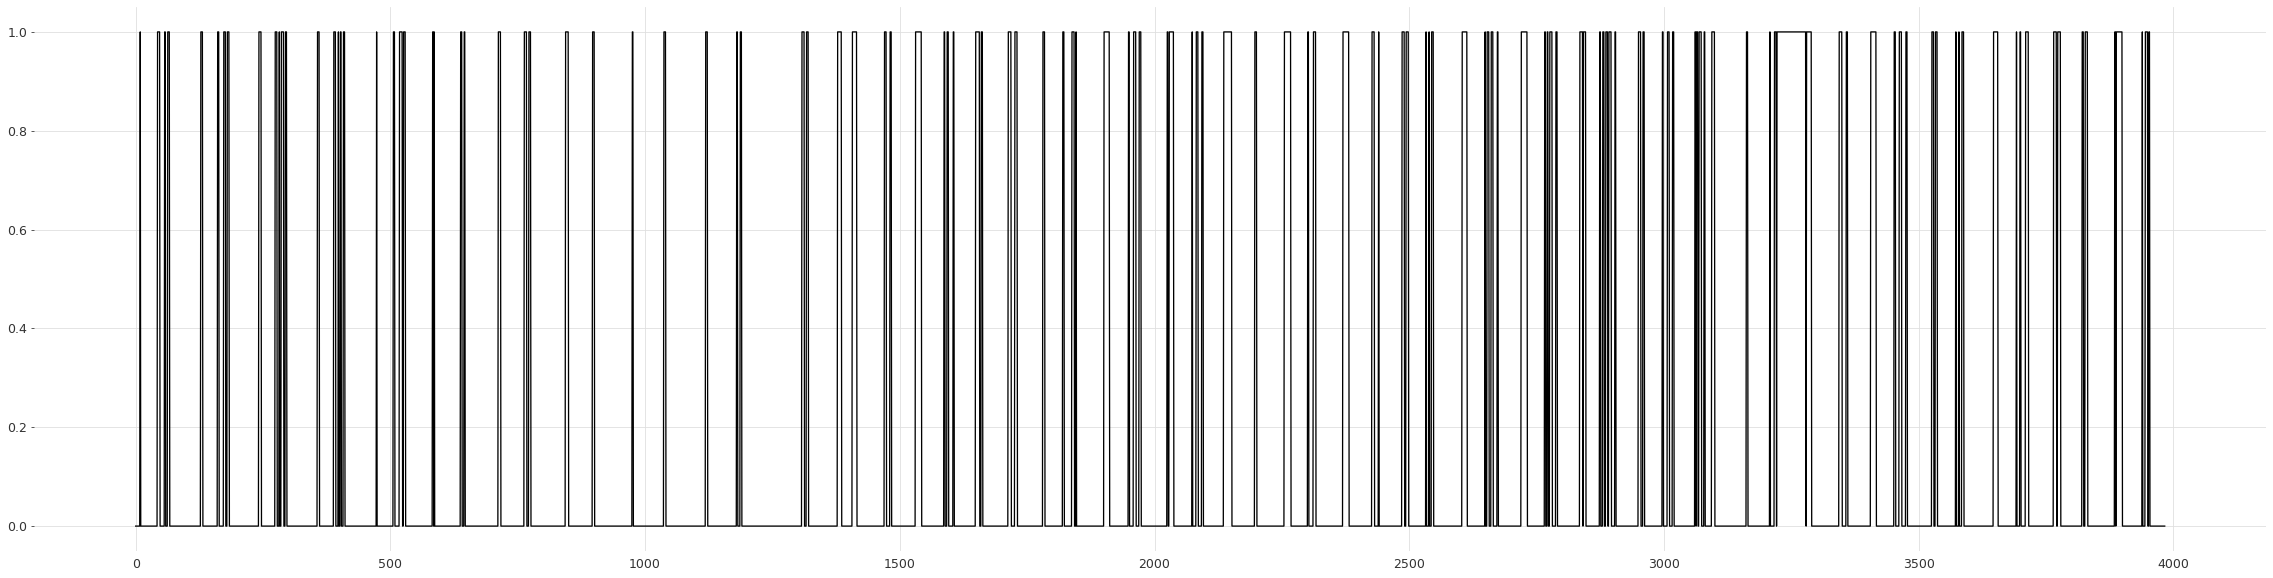

In [27]:
plt.plot(pred)

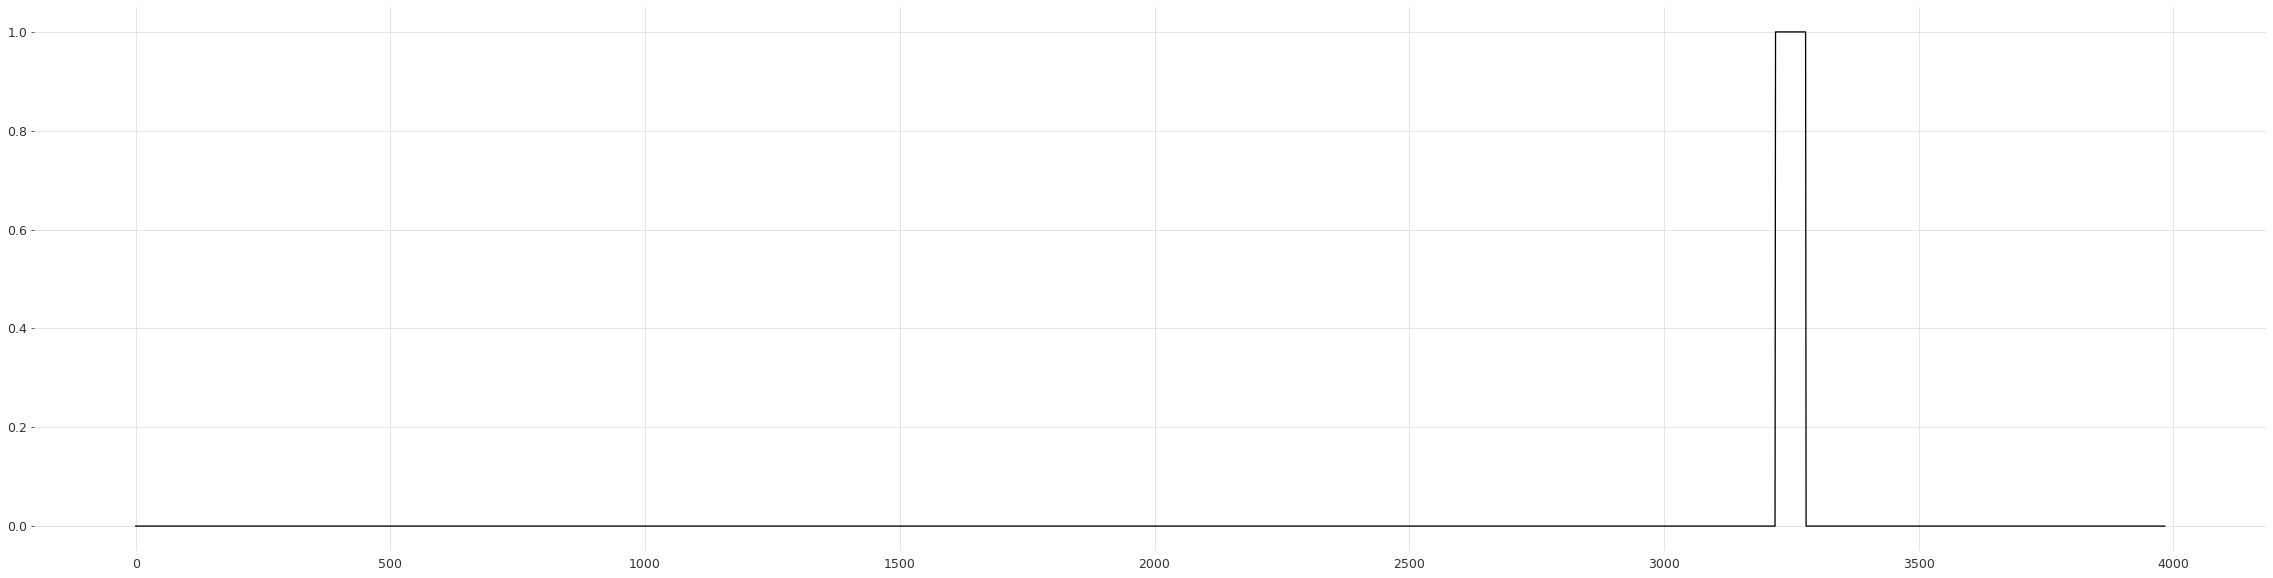

In [28]:
plt.plot(ts_labels)

In [ ]:
p = graph_data(test.test[0], test.test[1], 0)

In [ ]:
seperation = []
trials = [i for i in range(50, 500, 10)]

for w in range(50, 500, 10):
    clf = ECOD()
    tr_windows = sliding_window_view(test.train[0], w)
    clf.fit(tr_windows)
    
    test_data, test_label = test.get_test_with_window(w)
    ts_windows = sliding_window_view(test_data, w)

    pred = clf.decision_function(ts_windows)[:-1]

    sep = np.max(pred) - np.median(pred) 
    
    seperation.append(sep)

In [ ]:
max(seperation)

In [164]:
dict(zip(seperation, trials))

{116.27805986445392: 50,
 114.81263359168048: 60,
 133.13845077555345: 70,
 142.6781650756111: 80,
 148.13848277221584: 90,
 149.12005248421826: 100,
 148.20888136865682: 110,
 146.66315270729905: 120,
 142.2788714938127: 130,
 136.9546634944057: 140,
 131.4657365621066: 150,
 126.25899476605679: 160,
 119.46234315499947: 170,
 112.96253157560704: 180,
 105.04588544157099: 190,
 106.82559856107514: 200,
 119.46378392391784: 210,
 124.58729984936184: 220,
 126.06889999695397: 230,
 124.65968085926272: 240,
 124.5014911909658: 250,
 134.5834869909918: 260,
 137.44311744828644: 270,
 136.03237990345542: 280,
 132.5869643500032: 290,
 133.77095880565594: 300,
 129.84907340212135: 310,
 123.81565264376047: 320,
 119.78110642307672: 330,
 127.37801251389715: 340,
 129.6542974133274: 350,
 127.40304495778912: 360,
 123.55871678776987: 370,
 126.62795796755893: 380,
 130.57427497774597: 390,
 128.0750010499887: 400,
 121.96628662135083: 410,
 118.59467670189508: 420,
 124.64985178792415: 430,


In [170]:
w = 490

In [171]:
    clf = ECOD()
    tr_windows = sliding_window_view(test.train[0], w)
    clf.fit(tr_windows)
    
    test_data, test_label = test.get_test_with_window(w)
    ts_windows = sliding_window_view(test_data, w)

    pred = clf.decision_function(ts_windows)[:-1]

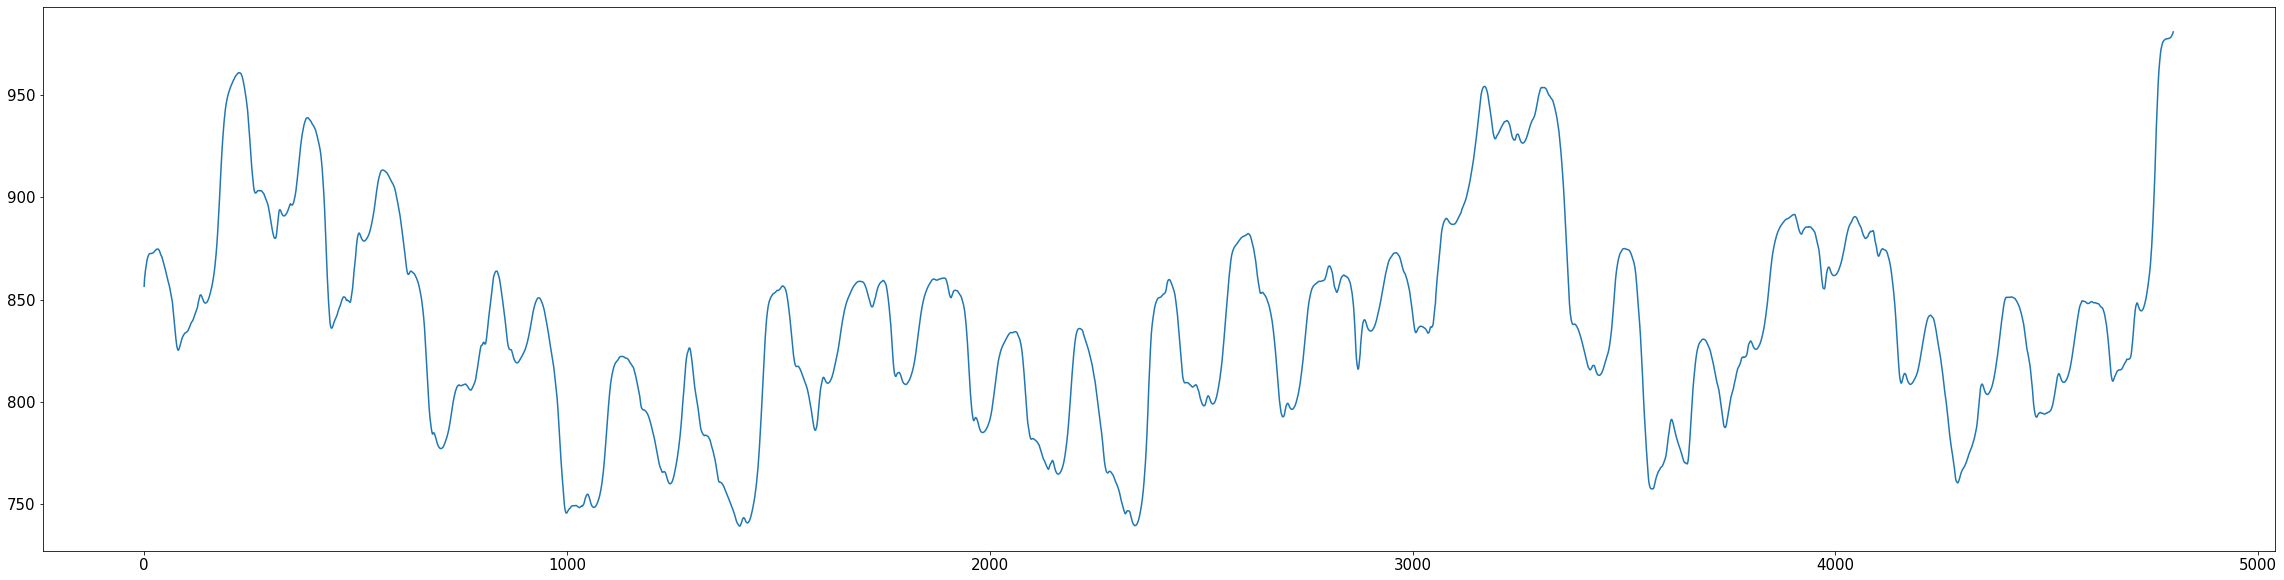

In [172]:
plt.plot(pred)

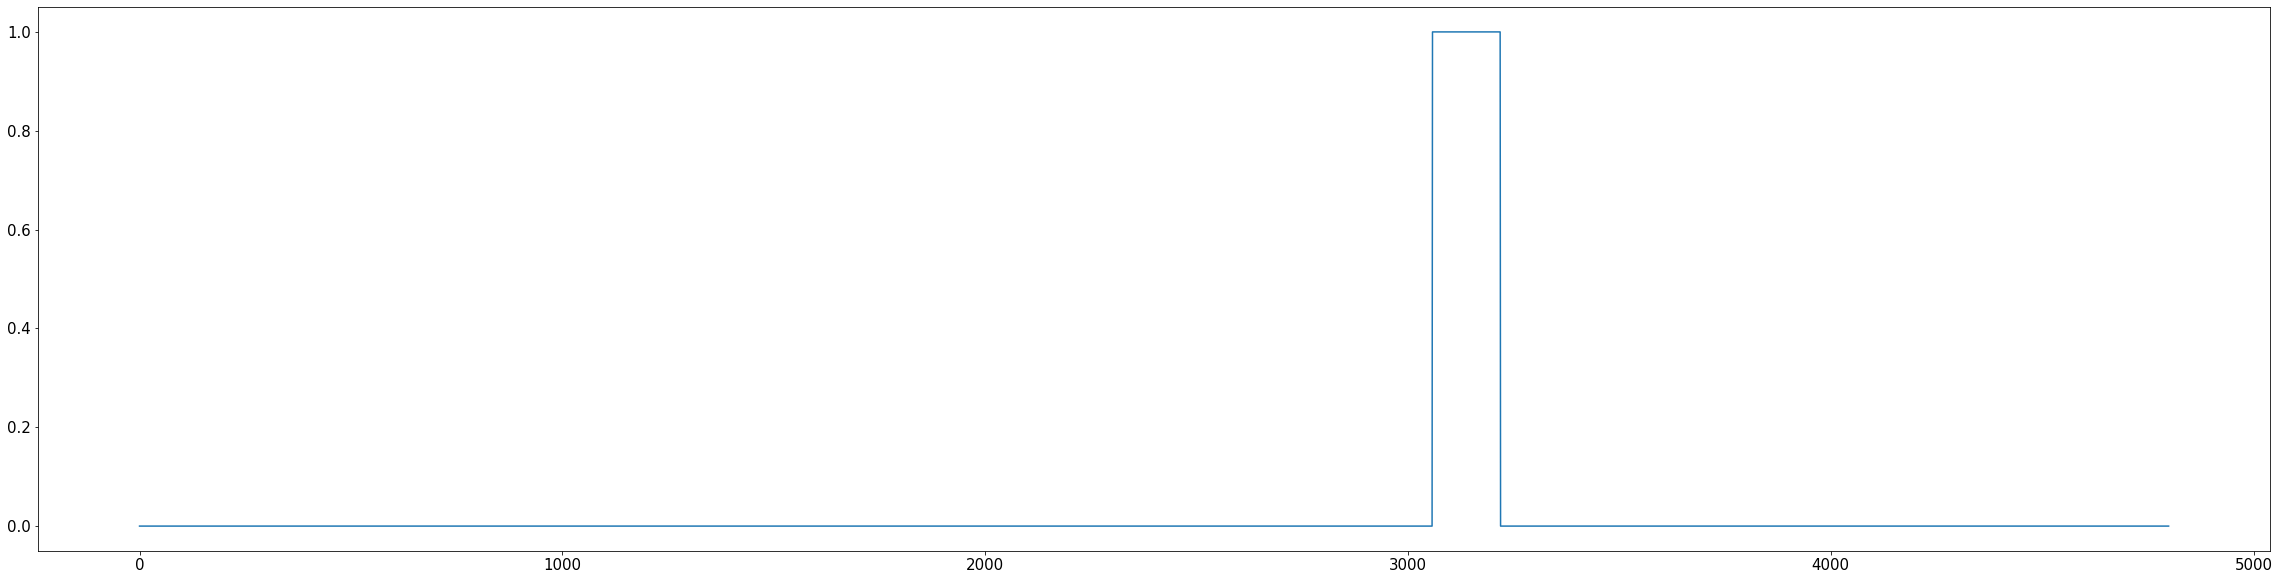

In [173]:
plt.plot(test_label)

# Result Analyzer

In [361]:
ROOT_DIR = "./data/ucr/"
SAVE_DIR = "./results/"


dirs = get_dirs_from_path(SAVE_DIR)

In [362]:
from tods.sk_interface.timeseries_processing.HoltWintersExponentialSmoothing_skinterface import (HoltWintersExponentialSmoothingSKI)

In [363]:
from sklearn.preprocessing import Normalizer

## Set Threshold 

In [448]:
import pandas as pd
from statsmodels.tsa.holtwinters import ExponentialSmoothing

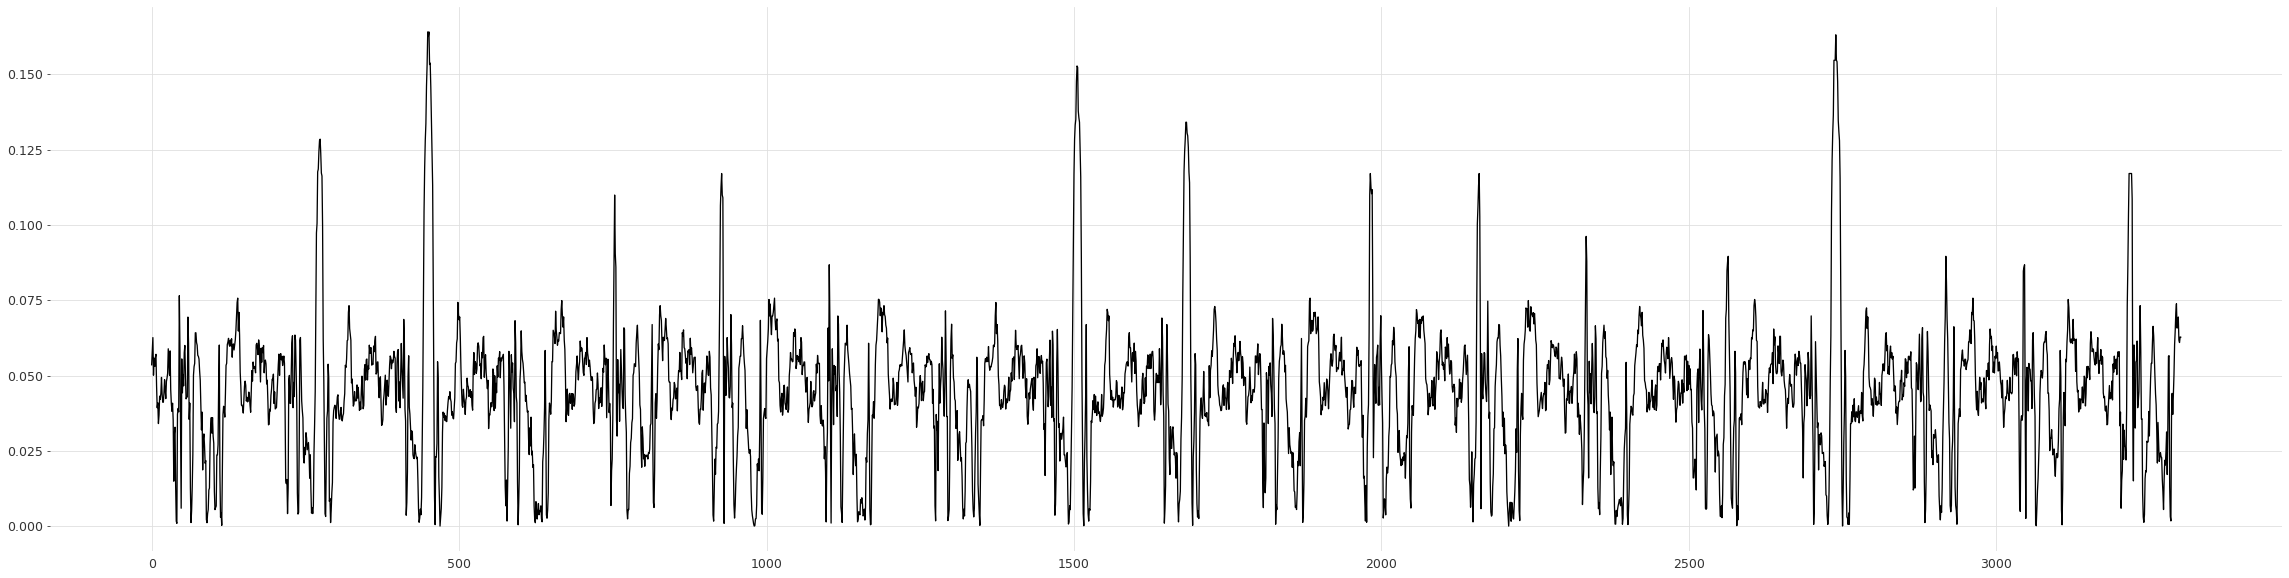

In [463]:
plt.plot(scores)

In [464]:
scores = np.abs(scores.flatten())

In [472]:
t = set_initial_threshold(0.98, scores)
t_spot = get_anomaly_threshold(1e-3, scores)
is_anom = scores.copy()
is_anom[is_anom > t_spot] = 1
is_anom[is_anom <= t_spot] = 0

In [473]:
print(t, t_spot)

0.11308024525136173 0.1624578454593072


In [9]:
def set_initial_threshold(pct_anom: float, scores) -> float:
    #sort data
    x = np.sort(scores)

    #calculate CDF values
    y = 1. * np.arange(len(scores)) / (len(scores) - 1)
    idx = (np.abs(y - pct_anom)).argmin()

    return x[idx]

def get_peak_set(t: float, scores):
    x = scores.copy()
    x = x[x > t]
    return x - t
    
def get_gpd_param(peak_set):
    y = peak_set.copy()
    mu = y.mean()
    var_y = y.var(ddof=1)
    
    sigma = mu/2 * (1 + mu ** 2 / var_y)
    gamma = 1/2 * (1 - mu ** 2 / var_y)
    
    return sigma, gamma

def get_anomaly_threshold(q, scores, initial_pct_anom = 0.98):
    t = set_initial_threshold(initial_pct_anom, scores)
    y = get_peak_set(t, scores)
    n_y = len(y)
    n = len(scores)
    sigma, gamma = get_gpd_param(y)
        
    new_threshold = t + sigma/gamma * ((q*n/n_y)**(-gamma) - 1)
    return new_threshold

## Visualize

In [11]:
dirs

[]

In [10]:
for d in dirs: [f if "preds" in f for f in get_files_from_path(SAVE_DIR + d)]

SyntaxError: invalid syntax (2224139842.py, line 2)

In [ ]:
transformer.fit()

In [93]:
def _eval_wo_label(df: pd.DataFrame) -> Tuple:
    """
    Returns a few quantitative metrics for us to use for evaluation when labels
    are not provided.
    Parameters
    -----------
    df: pd.Dataframe
        the dataframe with 'timestamp', 'value' and 'predict' columns
        where 'predict' is 1 for those predicted as anomalous and 0 otherwise.
    Returns
    ----------
    tuple
        (number of anomalies,
        % of anomnalies,
        avg. distance between mean and all anomalies (yaxis),
        avg. time distance between consecutive anomalies,
        avg. cycle distance between consecutive anomalies,
        maximum range between non anomaly points (yaxis)
        )
    """

    num_anomalies = df.predict.sum()
    percent_anomalies = num_anomalies/len(df)

    mean_val = df.value.mean()

    pred_anomalies = df[df['predict'] == 1]
    pred_non_anomalies = df[df['predict'] == 1]

    avg_anom_dist_from_mean_val = np.mean(pred_anomalies['value'].apply(lambda x: np.abs(x - mean_val)))
    try:
        avg_time_delta_between_anomalies = pred_anomalies.timestamp.diff().mean().total_seconds() / 3600
    except:
        avg_time_delta_between_anomalies = np.nan
    avg_cycles_delta_between_anomalies = pred_anomalies.index.to_series().diff().fillna(0).mean()

    max_range_non_anomalies = abs(pred_non_anomalies['value'].max() - pred_non_anomalies['value'].min())

    return (num_anomalies,
            percent_anomalies,
            avg_anom_dist_from_mean_val,
            avg_time_delta_between_anomalies,
            avg_cycles_delta_between_anomalies,
            max_range_non_anomalies)

def get_unlabeled_metrics(s: pd.Series, anomalies: pd.Series) -> tuple:
    """
    Helper function to format inputs before getting metrics
    Parameters
    -----------
    s: pd.Series containing values of time series with timestamp as the index
    anomalies: pd.Series containing whether this point is anomalous or not with timestamp as the index, same as above.
    Returns
    ----------
    tuple
        (number of anomalies,
        % of anomnalies,
        avg. distance between mean and all anomalies (yaxis),
        avg. time distance between consecutive anomalies,
        avg. cycle distance between consecutive anomalies,
        maximum range between non anomaly points (yaxis)
        )
    """
    df_res = pd.concat((s, anomalies), axis=1).reset_index()
    df_res.columns = ['timestamp', 'value', 'predict']
    df_res['predict'] = df_res['predict'].astype(int)

    metrics = _eval_wo_label(df_res)

    return metrics


In [92]:
def compute_objective(values, targets, predicted_anomalies):
    pred = predicted_anomalies.astype(int)

    (num_anomalies, percent_anomalies, avg_anom_dist_from_mean_val, avg_time_delta_between_anomalies,
         avg_cycles_delta_between_anomalies, max_range_non_anomalies) = get_unlabeled_metrics(values, predicted_anomalies)

    obj = 1e4 * percent_anomalies + max_range_non_anomalies - avg_cycles_delta_between_anomalies

    # If nan, should return number in case it always gives nan
    if np.isnan(obj):
        obj = 1e10
    return obj


## Scoring

In [173]:
DATA_DIR = "./data/ucr/"
SAVE_DIR = "./results/"


raw_dirs = get_dirs_from_path(SAVE_DIR)

In [183]:
dirs = get_dirs_from_path(SAVE_DIR)
dirs = [SAVE_DIR + d + "/" for d in dirs]

results = []
for d in dirs:
    for r in get_files_from_path(d):
        if "preds" in r: results.append(d+r)

In [184]:
files = get_files_from_path(DATA_DIR)

In [185]:
result_n = 28

# get original Data
for idx, f in enumerate(files):
    if result_n == int(f.split("_")[0]):
        file = UcrDataReader()(DATA_DIR+f)

# Get experiment outcomes
for idx, f in enumerate(raw_dirs):
    if result_n == int(f.split("_")[0]):
        results = []
        for r in get_files_from_path(dirs[idx]):
            if "preds" in r: results.append(dirs[idx]+r)


In [187]:
for r in results:
    arr = np.loadtxt(r)
    print(arr)

0.0
[95.06661744 95.28769433 94.30472768 ... 66.28652898 66.45339385
 65.39195909]
[93.96996335 93.2865403  92.83700423 ... 66.43063416 66.23028278
 65.87943021]
[95.47140341 94.91612238 93.93113483 ... 65.97248445 66.64010923
 66.81038943]
[95.01442198 94.98079431 94.11047057 ... 66.36877062 66.39158462
 65.23156446]
[94.96113441 95.48904757 94.17784358 ... 66.45071004 66.8164703
 64.90025825]
[96.44689147 94.79736931 93.89530963 ... 65.95523504 65.95982846
 66.02271046]


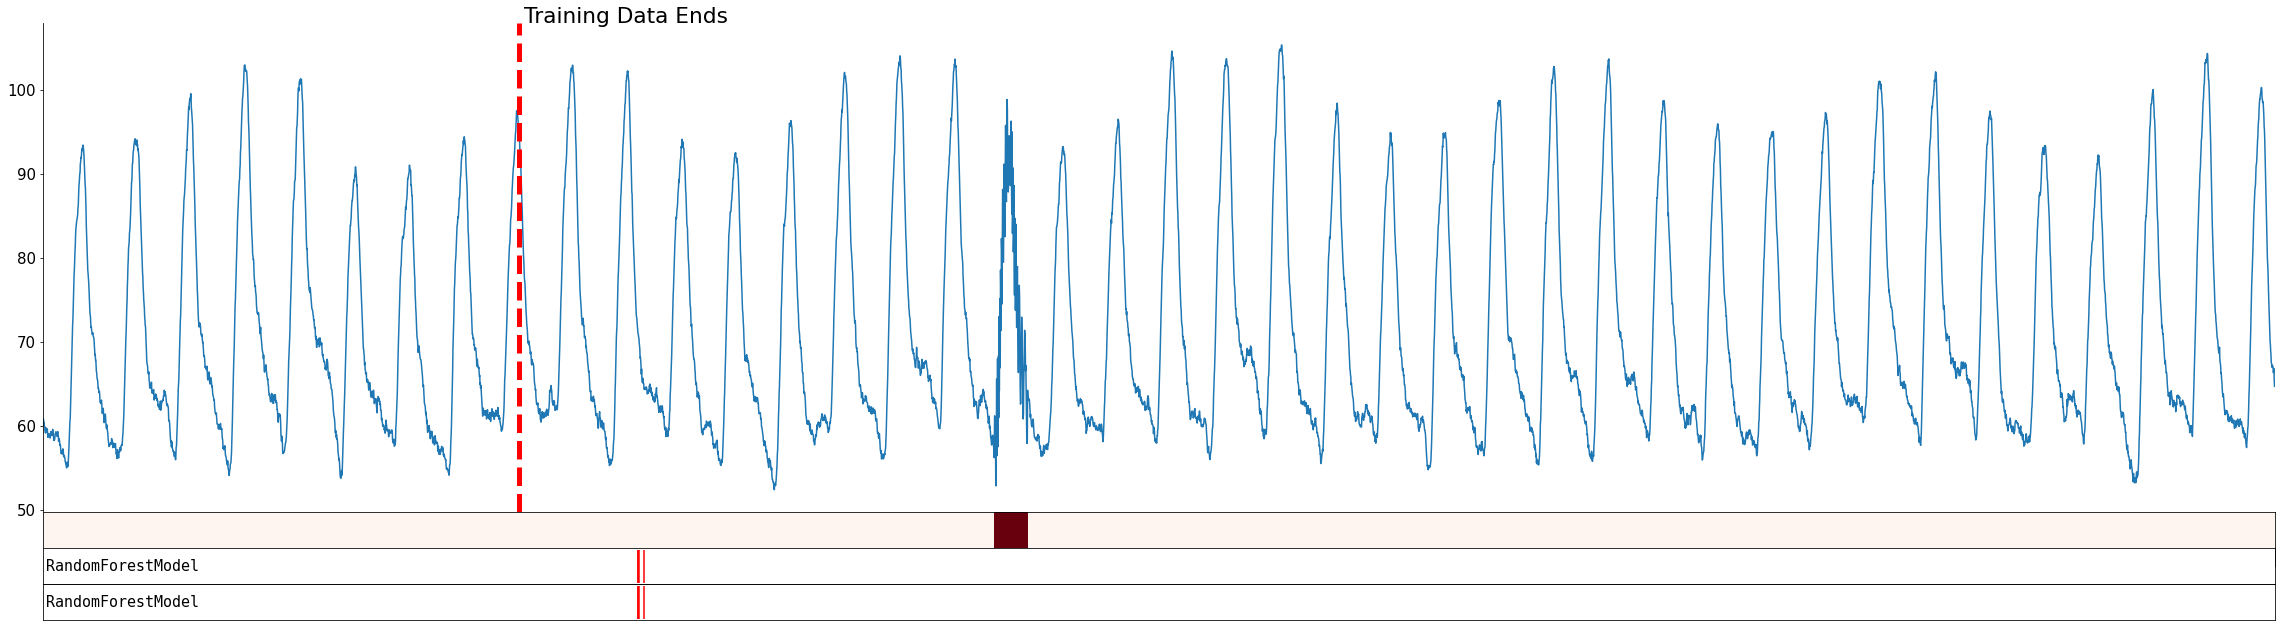

In [168]:
p = graph_data(file.series, file.labels, file.train_len)
ax1, ax2 = p.get_axes()

ax_new = p.add_axes([0.125,0.05,0.775,0.05], anchor="SW", sharex=ax1, label="test")



ax_new.text(10,0.5,"RandomForestModel", fontfamily="monospace", va="center")
ax_new.set_xticklabels([])
ax_new.set_xticks([])
ax_new.set_yticklabels([])
ax_new.set_yticks([])
ax_new.vlines([2000, 2001, 2002, 2020], 0, 1, colors="red")


ax_new = p.add_axes([0.125,0.1,0.775,0.05], anchor="SW", sharex=ax1, label="test")
ax_new.text(10,0.5,"RandomForestModel", fontfamily="monospace", va="center")
ax_new.set_xticklabels([])
ax_new.set_xticks([])
ax_new.set_yticklabels([])
ax_new.set_yticks([])
ax_new.vlines([2000, 2001, 2002, 2020], 0, 1, colors="red")

In [158]:
type(p)

matplotlib.figure.Figure

In [159]:
ax_new.text(0.5,0.5,"RandomForestModel", fontfamily="Consolas", va="center")

Text(0.5, 0.5, 'RandomForestModel')

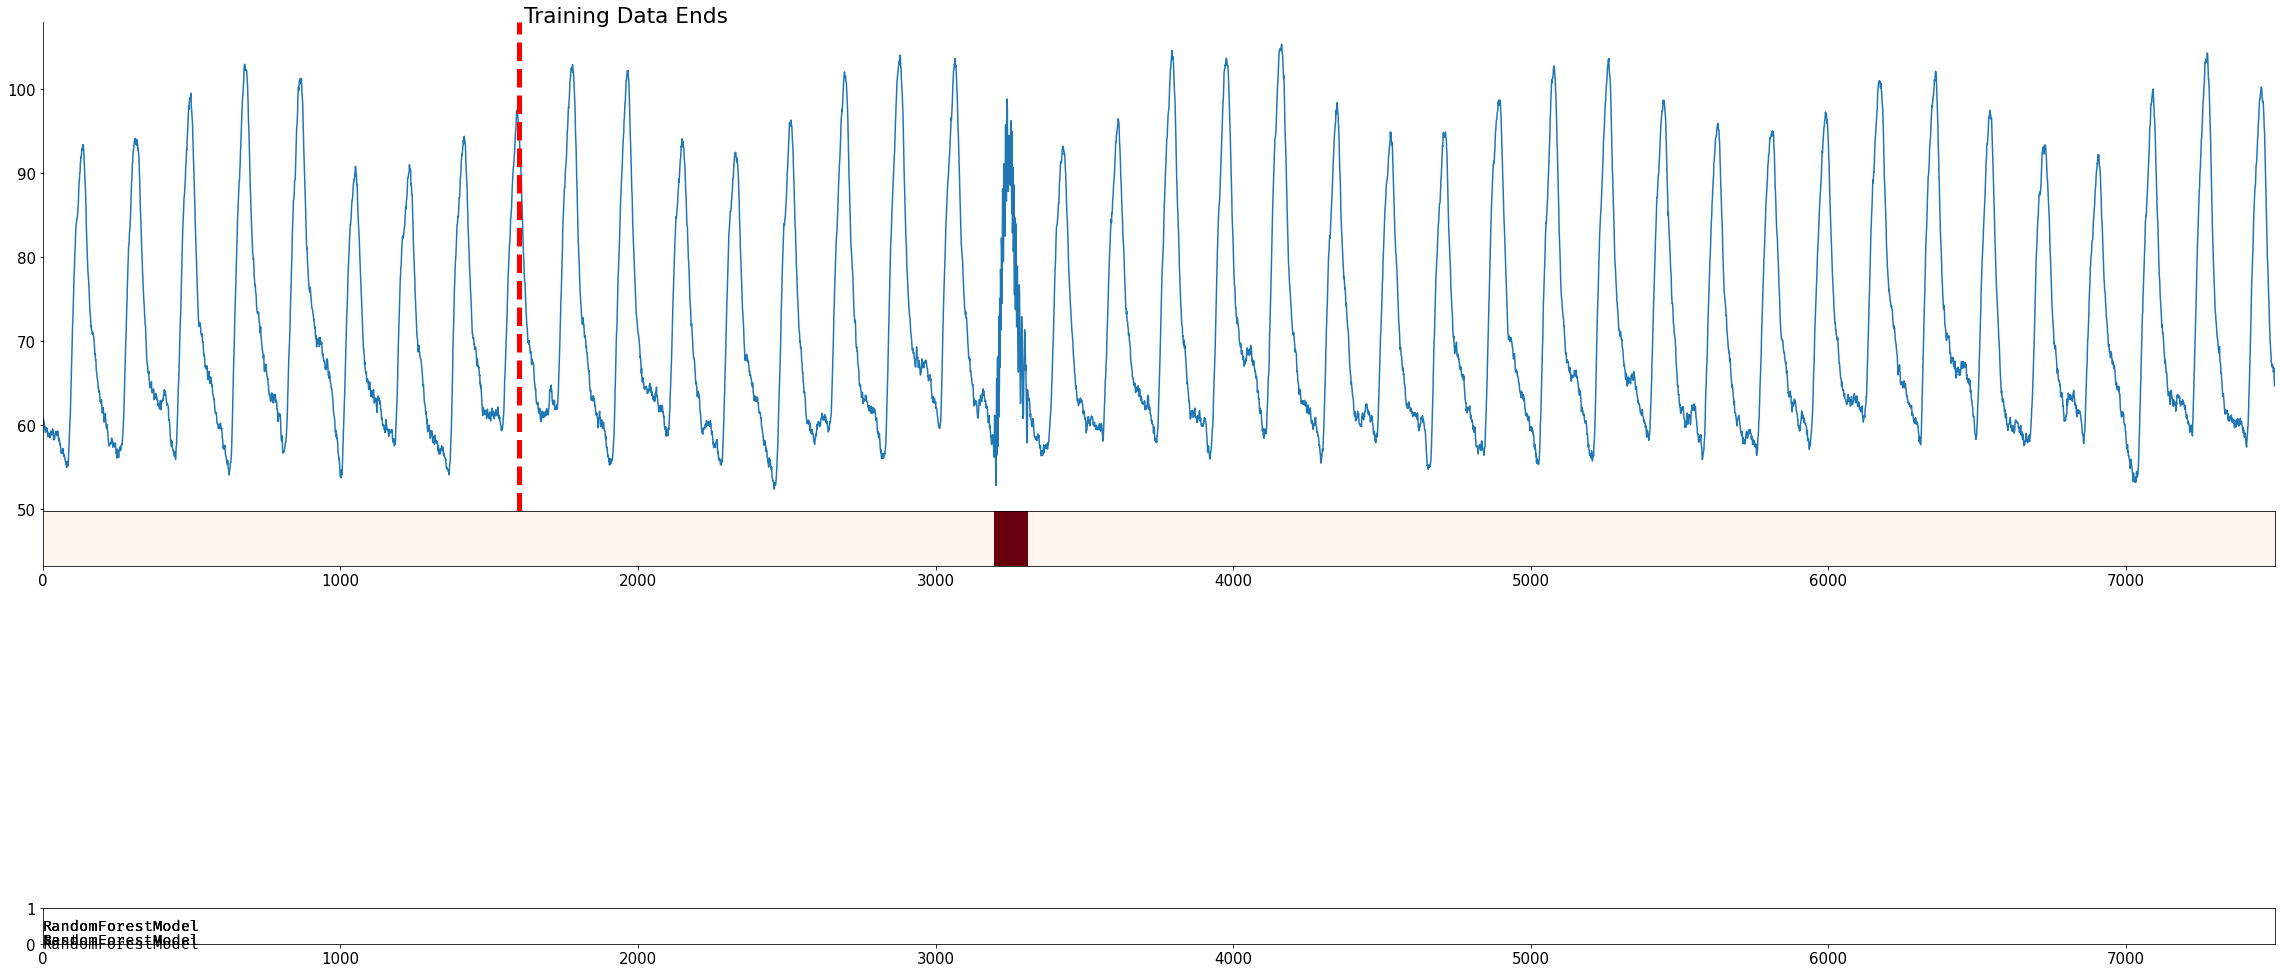

In [138]:
p

In [188]:
dirs

['./results/028_UCR_Anomaly_DISTORTEDInternalBleeding17_1600_3198_3309/',
 './results/029_UCR_Anomaly_DISTORTEDInternalBleeding18_2300_4485_4587/',
 './results/030_UCR_Anomaly_DISTORTEDInternalBleeding19_3000_4187_4197/',
 './results/031_UCR_Anomaly_DISTORTEDInternalBleeding20_2700_5759_5919/',
 './results/032_UCR_Anomaly_DISTORTEDInternalBleeding4_1000_4675_5033/',
 './results/033_UCR_Anomaly_DISTORTEDInternalBleeding5_4000_6200_6370/',
 './results/053_UCR_Anomaly_DISTORTEDWalkingAceleration1_1500_2764_2995/',
 './results/054_UCR_Anomaly_DISTORTEDWalkingAceleration5_2700_5920_5979/',
 './results/132_UCR_Anomaly_InternalBleeding10_3200_4526_4556/',
 './results/133_UCR_Anomaly_InternalBleeding14_2800_5607_5634/',
 './results/135_UCR_Anomaly_InternalBleeding16_1200_4187_4199/',
 './results/137_UCR_Anomaly_InternalBleeding18_2300_4485_4587/',
 './results/138_UCR_Anomaly_InternalBleeding19_3000_4187_4197/',
 './results/139_UCR_Anomaly_InternalBleeding20_2700_5759_5919/',
 './results/140_UC

In [ ]:
[SAVE_DIR + d + "/" for d in get_dirs_from_path("./results/")]

In [ ]:
set(dirs